# Forecasting

<p>In this lesson, we will practice forecasting using the following methods:  </p>
<ul>
<li>Last observed value  </li>
<li>Simple average  </li>
<li>Moving average  </li>
<li>Holt's Linear Trend  </li>
<li>Previous cycle  </li>
</ul>

---

<p>We will walk through steps from previous lessons to get the data ready to model</p>
<ul>
<li>Acquire data: `prepare.acquire_store_data()`  </li>
<li>Prepare data: `prepare.prep_store_data()`  </li>
<li>Split data: `prepare.split_store_data()`  </li>
</ul>
<p>Then we will forecast and evaluate using each method. </p>


---

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env
#import 

## Acquire

We will acquire the store-item-demand data for this lesson from the sql database.



In [4]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [5]:
query = 'SELECT stores.*, items.*, sales.sale_date, sales.sale_amount \
            FROM sales \
            JOIN stores USING (store_id) \
            JOIN items USING (item_id);'

df = pd.read_sql(query, get_connection('tsa_item_demand'))

In [6]:
df.head()


,store_id,store_address,store_zipcode,store_city,store_state,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_date,sale_amount
0,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2013-01-01,13
1,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2013-01-02,11
2,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2013-01-03,14
3,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2013-01-04,13
4,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2013-01-05,10


<h2 id="prepare">Prepare</h2>
<ol>
<li>sale_date to datetime</li>
<li>sort values by date</li>
<li>set index</li>
<li>new field: dollars_sold = sale_amount * item_price</li>
<li>rename sale_amount to items_sold to make the two columns easier to understand what the data represents. </li>
<li>resample daily (The original granularity is daily, but there are multiple records of the same days across multiple stores.)</li>
<li>remove leap days!</li>
</ol>

In [7]:
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.sale_date)).\
            sort_values('ds').\
            assign(dollars_sold = df.sale_amount * df.item_price).\
            assign(items_sold = df.sale_amount).\
            groupby(['ds'])[['dollars_sold', 'items_sold']].sum().\
            reset_index().set_index('ds')

df = prep_data(df)

df = df[df.index != '2016-02-29']

NumExpr defaulting to 8 threads.


In [8]:
df.head()

,dollars_sold,items_sold
ds,,
2013-01-01,73844.01,13696
2013-01-02,73570.58,13678
2013-01-03,78169.48,14488
2013-01-04,84467.73,15677
2013-01-05,87621.85,16237


We will resample to daily, but essentially what we are doing is grouping by the day and aggregating using sum. The original granularity is daily, but there are multiple records of the same days across multiple stores.

<h2 id="split">Split</h2>
<ol>
<li>We will use the training proportion method to split.    </li>
<li>Identify the total length of the dataframe and multiple by <code>train_prop</code> to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.   (<code>x = train_prop * 100</code>)  </li>
<li>Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.  </li>
<li>Return train and test dataframes.  </li>
</ol>

In [9]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]


In [16]:
# Does the length of each df equate to the length of the original df?

print(len(train) + len(validate) + len(test) == len(df))


True


In [15]:
print(train.shape)
print(validate.shape)
print(test.shape)

(912, 2)
(547, 2)
(366, 2)


In [17]:
# Does the first row of original df equate to the first row of train?

print(df.head(1) == train.head(1))


            dollars_sold  items_sold
ds                                  
2013-01-01          True        True


In [18]:
# Is the last row of train the day before the first row of validate? And the same for validate to test?

pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,dollars_sold,items_sold
ds,,
2016-12-30,120033.64,22296
2016-12-31,128009.31,23792


In [19]:
# Is the last row of test the same as the last row of our original dataframe?

pd.concat([test.tail(1), df.tail(1)])


,dollars_sold,items_sold
ds,,
2017-12-31,140905.74,26420
2017-12-31,140905.74,26420


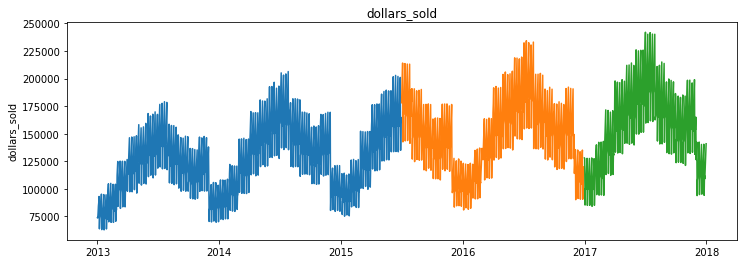

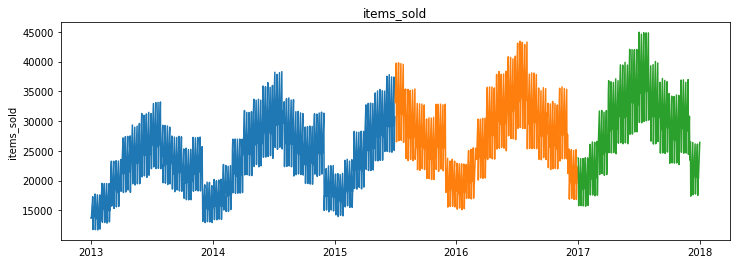

In [20]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

<p>Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow. </p>
<p><code>evaluate()</code> will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.  </p>


In [21]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

<p><code>plot_and_eval()</code> will use the evaluate function and also plot train and test values with the predicted values in order to compare performance. </p>


In [23]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

<p>Write <code>append_eval_df(model_type)</code> to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our <code>eval_df</code> data frame object. Which we will create an empty <code>eval_df</code> dataframe object to start. </p>


In [25]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [26]:
eval_df


,model_type,target_var,rmse


---

<h2 id="forecast">Forecast</h2>
<h3 id="last-observed-value">Last observed value</h3>
<p>The simplest method for forecasting is to predict all future values to be the last observed value.  </p>
<p><strong>Make Predictions</strong></p>
<d

In [27]:
items = train['items_sold'][-1:][0]
dollars = round(train['dollars_sold'][-1:][0],2)

yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]}, 
                       index = validate.index)

yhat_df.head(2)

,items_sold,dollars_sold
ds,,
2015-07-02,30703,164573.2
2015-07-03,30703,164573.2


In [28]:
train.tail(1)

,dollars_sold,items_sold
ds,,
2015-07-01,164573.2,30703


<p>You can see, when peeking into yhat_df, that every predicted value is the same.  </p>
<p><strong>Plot Actual vs. Predicted Values</strong></p>
<p>Now, let's plot actual and predicted values</p>


dollars_sold -- RMSE: 35402


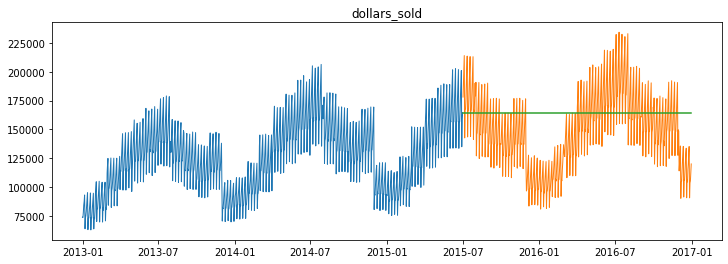

items_sold -- RMSE: 6621


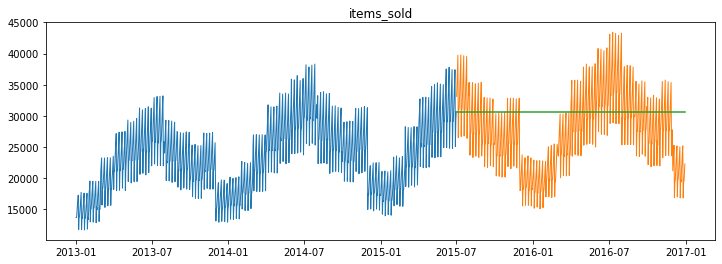

In [29]:
for col in train.columns:
    plot_and_eval(col)

<p><strong>Evaluate</strong> </p>
<p>Evaluate using MSE and RMSE, and add evaluation metrics to <code>eval_df</code></p>


In [30]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

In [31]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0


<h3 id="simple-average">Simple Average</h3>
<p>Take the simple average of historical values and use that value to predict future values.   </p>
<p>This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. </p>


In [32]:
items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'items_sold': [items],
                            'dollars_sold': [dollars],
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

<p><strong>Plot Actual vs. Predicted Values</strong></p>
<p>Now, let's plot and evaluate the performance of our time series model using <strong>Simple Average</strong></p>


dollars_sold -- RMSE: 39664


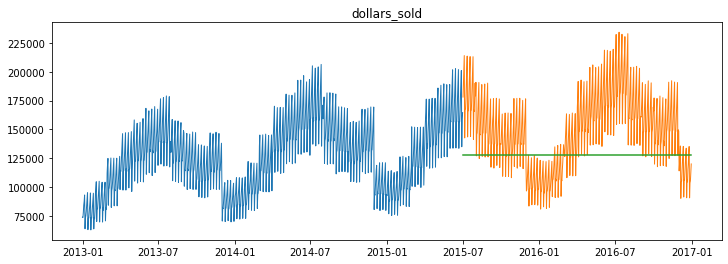

items_sold -- RMSE: 7378


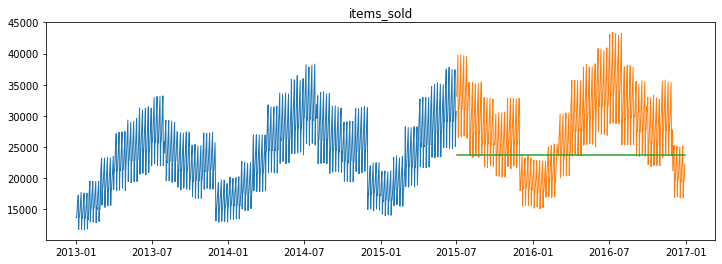

In [33]:
for col in train.columns:
    plot_and_eval(col)

<p><strong>Evaluate</strong></p>
<p>Evaluate using MSE and RMSE, and add evaluation metrics to <code>eval_df</code></p>


In [34]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [35]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0


<h3 id="moving-average">Moving Average</h3>
<p>In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value. </p>
<p><strong>Make Predictions</strong></p>


In [36]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

items = round(train['items_sold'].rolling(period).mean().iloc[-1], 2)
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,items_sold,dollars_sold
ds,,
2015-07-02,31432.77,168957.91
2015-07-03,31432.77,168957.91
2015-07-04,31432.77,168957.91


dollars_sold -- RMSE: 37378


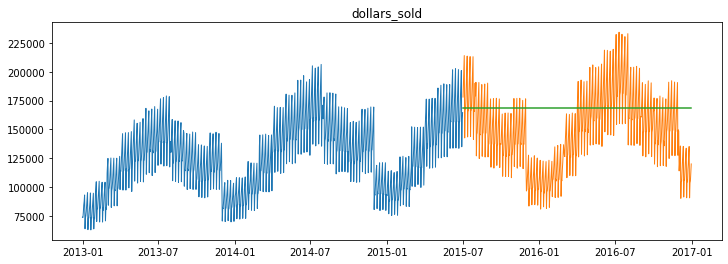

items_sold -- RMSE: 6954


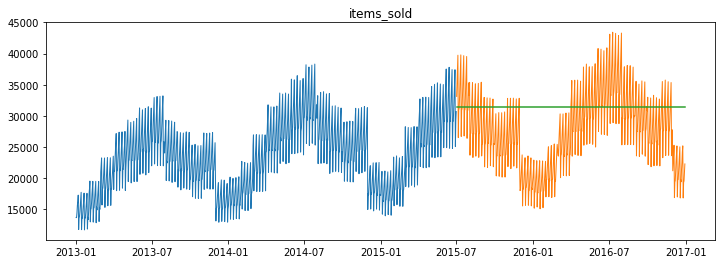

In [37]:
for col in train.columns:
    plot_and_eval(col)

In [38]:
# Evaluate

for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)

Let's try out several other values for periods:


In [39]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    items = round(train['items_sold'].rolling(p).mean().iloc[-1], 2)
    dollars = round(train['dollars_sold'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'items_sold'
                            )
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'dollars_sold'
                            )

In [40]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30d moving average,dollars_sold,37378.0
...,...,...,...
13,26d moving average,dollars_sold,37640.0
14,52d moving average,items_sold,6563.0
15,52d moving average,dollars_sold,35322.0
16,104d moving average,items_sold,6101.0


Which is best so far?



In [41]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
16,104d moving average,items_sold,6101.0
17,104d moving average,dollars_sold,32803.0


<h3 id="holts-linear-trend">Holt's Linear Trend</h3>
<p>Exponential smoothing applied to both the average and the trend (slope).  </p>
<ul>
<li><span class="arithmatex"><span class="MathJax_Preview">\alpha</span><script type="math/tex">\alpha</script></span> / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   </li>
<li><span class="arithmatex"><span class="MathJax_Preview">\beta</span><script type="math/tex">\beta</script></span> / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. </li>
</ul>
<p><strong>Seasonal Decomposition</strong></p>
<p>First, let's take a look at the seasonal decomposition for each target. </p>


dollars_sold 



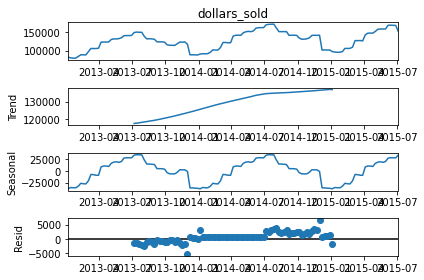

items_sold 



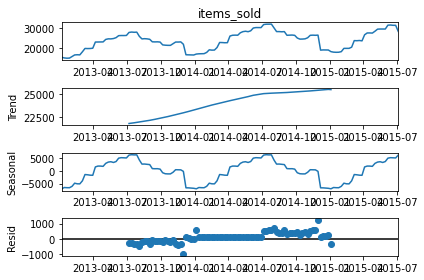

In [42]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

<h4 id="basic-holts-linear-trend">Basic Holt's Linear Trend</h4>
<p><strong>Make Predictions</strong></p>
<p>Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. </p>
<p>Holt: </p>
<ul>
<li>exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)</li>
</ul>
<p>fit: </p>
<ul>
<li>smoothing_level (<span class="arithmatex"><span class="MathJax_Preview">\alpha</span><script type="math/tex">\alpha</script></span>): value between (0,1)</li>
<li>smoothing_slope (<span class="arithmatex"><span class="MathJax_Preview">\beta</span><script type="math/tex">\beta</script></span>): value between (0,1)</li>
</ul>

In [43]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

dollars_sold -- RMSE: 34700


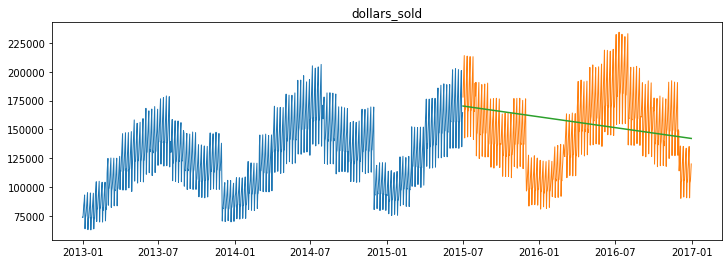

items_sold -- RMSE: 6464


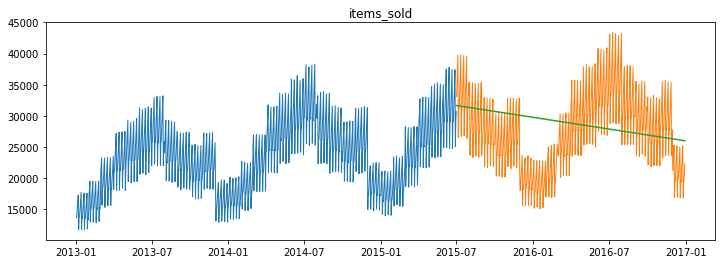

In [46]:
# Plot
for col in train.columns:
    plot_and_eval(target_var = col)

In [45]:
# Evaluate

for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

<h3 id="predict-based-on-previous-cycle">Predict Based on Previous Cycle</h3>
<p>Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. </p>
<p>If a primary cycle is weekly, then you may want to do this on a week-over-week cadence. </p>
<p>In the below example:<br />
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. </p>
<p>Let's get started....</p>
<p><strong>Re-split data</strong></p>

In [47]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [54]:
train.diff(365)

,dollars_sold,items_sold
ds,,
2013-01-01,NaN,NaN
2013-01-02,NaN,NaN
2013-01-03,NaN,NaN
2013-01-04,NaN,NaN
2013-01-05,NaN,NaN
...,...,...
2015-12-27,10605.96,1951.0
2015-12-28,-36765.99,-6963.0
2015-12-29,18886.81,3515.0


In [48]:
yhat_df = train['2015'] + train.diff(365).mean()


In [49]:
pd.concat([yhat_df.head(1), validate.head(1)])


,dollars_sold,items_sold
ds,,
2015-01-01,104337.620493,19411.813699
2016-01-01,107875.260000,20158.000000


In [50]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

365

dollars_sold -- RMSE: 28087


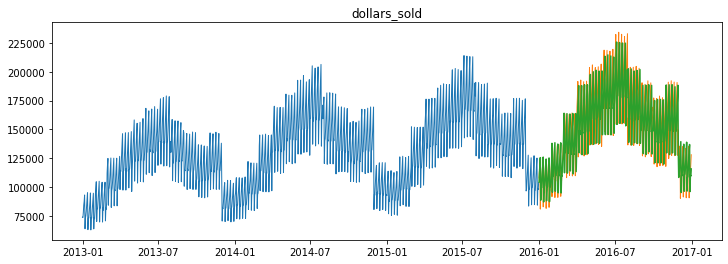

items_sold -- RMSE: 5223


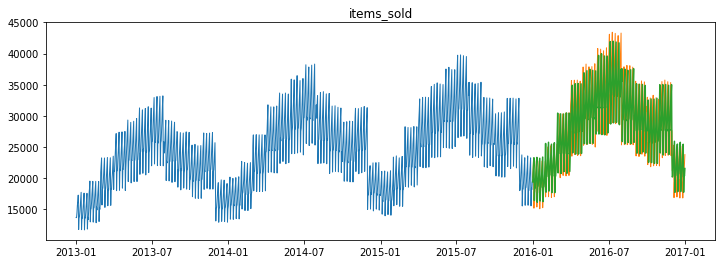

In [51]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

## Conclusion

Which model did the best?

In [52]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
20,previous year,dollars_sold,28087.0
21,previous year,items_sold,5223.0


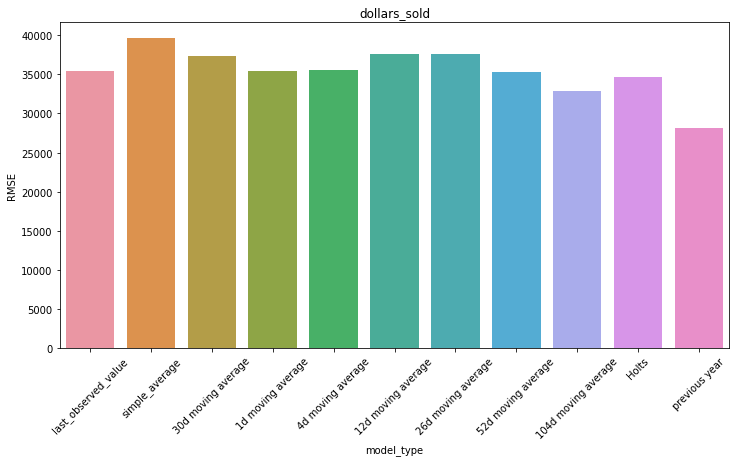

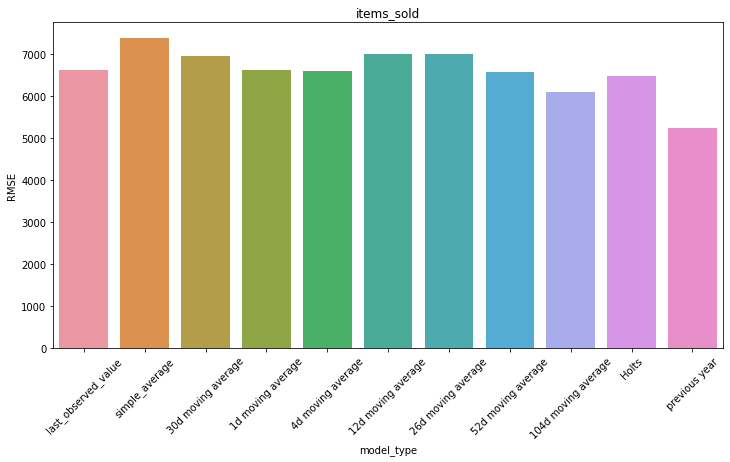

In [53]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

Run on test

In [55]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

In [56]:
rmse_dollars = round(sqrt(mean_squared_error(test['dollars_sold'], yhat_df['dollars_sold'])), 0)
rmse_items = round(sqrt(mean_squared_error(test['items_sold'], yhat_df['items_sold'])), 0)

In [57]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

rmse - dollars_sold:  27115.0
rmse - items_sold:  5041.0


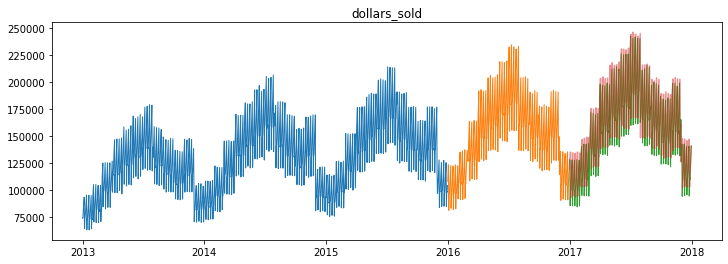

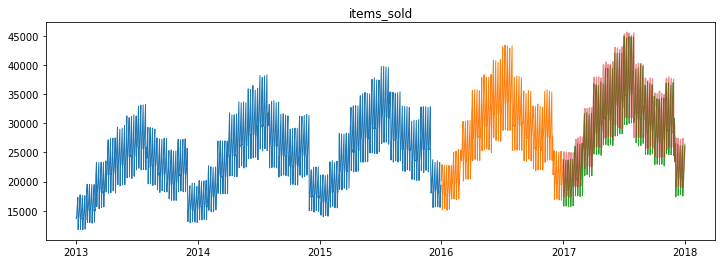

In [58]:
print("rmse - dollars_sold: ", rmse_dollars)
print("rmse - items_sold: ", rmse_items)

for col in train.columns:
    plot_and_eval(col)